### Introduction to Nilearn and image manipulation

The goal of this notebook is to help get you comfortable with manipulating functional and anatomical images using nilearn. We'll be using the techniques we learned here in our final analysis...

#### Content:
1. Basic Image Operations and Masking
2. Resampling data to work across modalities (T1/FUNC)

In [13]:
import os #to access file-system
import nilearn as nil 
import matplotlib.pyplot as plt #to enable plotting within notebook
from nilearn import image as img
from nilearn import plotting as plot

In [14]:
#magic function to view matplotlib images in notebook
%matplotlib inline 

Let's grab some sample images from fmriprep

In [17]:
#Base directory for fmriprep output
fmriprep_dir = '../data/{mod}/'
t1_dir = fmriprep_dir.format(mod='anat') 
func_dir = fmriprep_dir.format(mod='func')

In [18]:
#Display files inside of anatomy folder 
os.listdir(t1_dir) 

['sub-50083_T1w_pial.R.surf.gii',
 'sub-10206_T1w_brainmask.nii.gz',
 'sub-10206_T1w_dtissue.nii.gz',
 'sub-10206_T1w_inflated.L.surf.gii',
 'sub-10206_T1w_inflated.R.surf.gii',
 'sub-10206_T1w_midthickness.L.surf.gii',
 'sub-10206_T1w_midthickness.R.surf.gii',
 'sub-10206_T1w_pial.L.surf.gii',
 'sub-10206_T1w_pial.R.surf.gii',
 'sub-10206_T1w_preproc.nii.gz',
 'sub-10206_T1w_smoothwm.L.surf.gii',
 'sub-10206_T1w_smoothwm.R.surf.gii',
 'sub-10206_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz',
 'sub-10557_T1w_pial.L.surf.gii',
 'sub-10557_T1w_pial.R.surf.gii',
 'sub-10557_T1w_preproc.nii.gz',
 'sub-10557_T1w_smoothwm.L.surf.gii',
 'sub-10557_T1w_smoothwm.R.surf.gii',
 'sub-10557_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz',
 'sub-10557_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz',
 'sub-10557_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz',
 'sub-10557_T1w_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz',
 'sub-10557_T1w_space-MNI152NLin2009cAsym_prepro

### Warming up with Nilearn 

#### Basic Image operations
Here we show how easy it is to apply a mask to nifti images using nilearn. 
We first pick an example T1 image and mask from the fmriprep output, then we apply the mask and view the result...

In [4]:
#How does nilearn deal with images
ex_T1 = os.path.join(t1_dir,'sub-10206_T1w_preproc.nii.gz')
ex_bm = os.path.join(t1_dir,'sub-10206_T1w_brainmask.nii.gz')

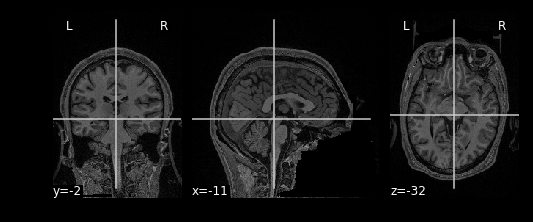

In [5]:
#Viewing T1
plot.plot_anat(ex_T1)

Nilearn uses nibabel under the hood to store nifti images. So you can think of images (similar to nibabel) as a 3D array (volume) with values assigned to each (x,y,z) coordinate. With 3D arrays we can perform operations and nilearn makes this easy!

Say we wanted to invert a T1 image, that is flip the colorscale. We could do this as follows:

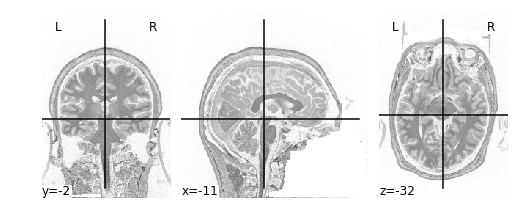

In [6]:
#Inverting a T1 image example
invert_img = nil.image.math_img('1-a',a=ex_T1)
plot.plot_anat(invert_img) 

Now we could use a similar technique to apply a mask. 
A mask is simply a 3D volume with 0's and 1's. The 1's indicate the areas in which areas are to be preserved. 

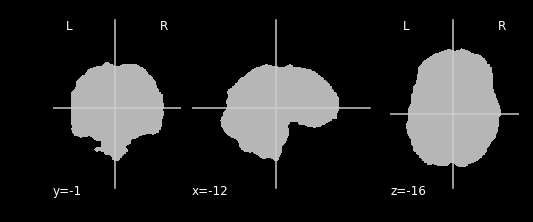

In [7]:
#Viewing mask
plot.plot_anat(ex_bm) 

The idea behind applying a mask is multiplying the mask directly by the image in an element-wise fashion. 
The end result is that all voxels (x,y,z) in the T1 image corresponding with a 1 in the mask with the same coordinate (x,y,z) is preserved. Everything else is put to 0.

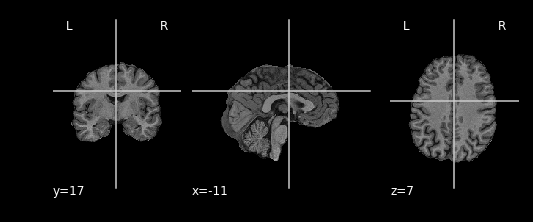

In [8]:
#Applying a mask is as easy as using the straight formula
masked_t1 = nil.image.math_img('a*b',a=ex_T1,b=ex_bm)
plot.plot_anat(masked_t1)

**Exercise**: 
Try applying the mask but getting everything but the brain!

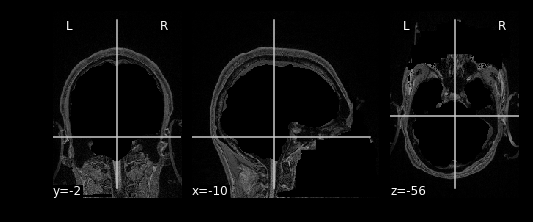

In [10]:
#Solution
inverted_mask_t1 = nil.image.math_img('a*(1-b)',a=ex_T1,b=ex_bm)
plot.plot_anat(inverted_mask_t1) 

#### Resampling
Recall from our nibabel exploration of neuroimaging data:

- T1 images are typically composed of voxels that are 1x1x1 in dimension
- Functional images are typically composed of voxels that are 2x2x2 in dimension

If we'd like to overlay our functional on top of our T1 (for visualization purposes, or analyses), then we need to match the size of the voxels! 

Think of this like trying to overlay a 10x10 JPEG and a 20x20 JPEG on top of each other. To get perfect overlay we need to resize (or more accurately *resample*) our JPEGs to match!

**Note**: 
Resampling is a method of interpolating in between data-points. When we stretch an image we need to figure out what goes in the spaces that are created via stretching - resampling does just that. In fact, resizing any type of image is actually just resampling to new dimensions. 

Let's resampling some MRI data using nilearn. 

**Goal**: Match the dimensions of the structural image to that of the functional image

In [45]:
#Files we'll be using (Notice that we're using _space-MNI..._ which means they are normalized brains)
ex_mni_T1 = os.path.join(t1_dir,'sub-10206_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz')
ex_mni_FUNC = os.path.join(func_dir,'sub-10206_task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')

Note below that when we load an image, it reads in as a nibabel image. 
Meaning we can use the same utilities we used in nibabel on this data!

In [42]:
t1 = img.load_img(ex_mni_T1)
func = img.load_img(ex_mni_FUNC)
print(type(t1))

<class 'nibabel.nifti1.Nifti1Image'>


Now we demonstrate our problem with the dimensions of the image not matching

In [43]:
print(t1.shape)
print(func.shape)

(193, 229, 193)
(65, 77, 49, 152)


Resampling in nilearn is as easy as telling it which image you want to sample and what the target image is.
Structure of function:

img.resample_to_img(source_img,target_img,interpolation) 
- source_img = the image you want to sample
- target_img = the image you wish to *resample to* 
- interpolation = the method of interpolation

A note on **interpolation**

nilearn supports 3 types of interpolation, the one you'll use depends on the type of data you're resampling!
1. **continuous** - Interpolate but maintain some edge features.  Ideal for structural images where edges are well-defined. Uses $3^\text{rd}$-order spline interpolation.
2. **linear (default)** - Interpolate uses a combination of neighbouring voxels - will blur. Uses trilinear interpolation.
3. **nearest** - matches value of closest voxel (majority vote from neighbours). This is ideal for masks which are binary since it will preserve the 0's and 1's and will not produce in-between values (ex: 0.342). Also ideal for numeric labels where values are 0,1,2,3... (parcellations). Uses nearest-neighbours interpolation with majority vote.


(65, 77, 49)
(65, 77, 49, 152)


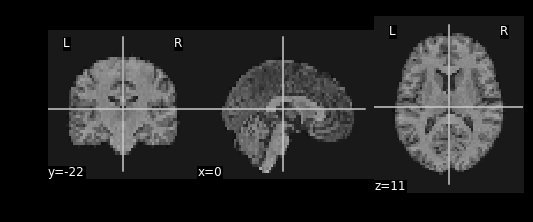

In [75]:
#Try playing around with methods of interpolation
#options: 'linear','continuous','nearest'
resamp_t1 = img.resample_to_img(source_img=t1,target_img=func,interpolation='continuous')
print(resamp_t1.shape)
print(func.shape)
plot.plot_anat(resamp_t1)

**Exercise**

Using **Native** T1 and **T1w** resting state functional do the following:
1. Resample the native T1 image to resting state size
2. Replace the brain in the T1 image with the first frame of the resting state brain

In [55]:
#Files we'll need
ex_T1 = os.path.join(t1_dir,'sub-10206_T1w_preproc.nii.gz')
ex_t1_bm = os.path.join(t1_dir,'sub-10206_T1w_brainmask.nii.gz')
ex_func = os.path.join(func_dir,'sub-10206_task-rest_bold_space-T1w_preproc.nii.gz')
ex_func_bm = os.path.join(func_dir,'sub-10206_task-rest_bold_space-T1w_brainmask.nii.gz')

In [53]:
#Step 1: Resample T1 --> Resting state
resamp_t1 = img.resample_to_img(source_img=ex_T1,target_img=ex_FUNC,interpolation='continuous') 

#Step 2: We need to resample the mask as well!
resamp_bm = img.resample_to_img(source_img=ex_bm,target_img=resamp_t1,interpolation='nearest')

#Step 3: Mask out the T1 image
removed_t1 = img.math_img('a*(1-b)',a=resamp_t1,b=resamp_bm)

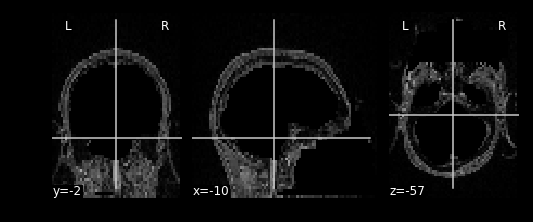

In [54]:
#Visualize resampled and removed brain
plot.plot_anat(removed_t1)

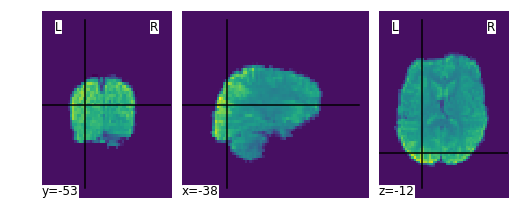

In [62]:
#Step 4: Load in the first frame of the resting state image
func_img = img.load_img(ex_func) 
first_func_img = func_img.slicer[:,:,:,0]

#Step 5: Mask the functional image and visualize
masked_func = img.math_img('a*b',a=first_func_img,b=ex_func_bm)
plot.plot_img(masked_func)

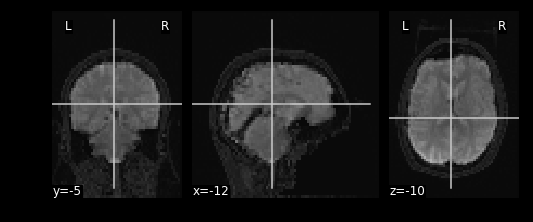

In [65]:
#Now overlay the functional image on top of the anatomical
combined_img = img.math_img('a+b',a=removed_t1,b=masked_func)
plot.plot_anat(combined_img)

### Finished!
Hopefully you've gained some intuition and comfort in dealing with MRI images using nilearn/nibabel. 

Now we'll take what we've used here, add some additional features and perform a full analysis on a dataset